## 🏗️ Stage 2: Training Foundations and Regularization

### Topics:
- **Loss Functions**:
  - Cross-Entropy Loss (for classification) 🔢
  - Mean Squared Error (for regression) 📉
- **Regularization**:
  - L1 and L2 ,Dropout, Batch Normalization
- **Weight Initialization**:
  - Xavier/Glorot Initialization
  - He Initialization 🧠
- **Overfitting vs. Underfitting**:
  - Bias-Variance Tradeoff ⚖️
  - Techniques: Early Stopping, Model Complexity Control

### 🔧 Loss Functions

Loss functions formalize the objective we aim to minimize during model training. They guide the optimization algorithm via gradients computed through backpropagation.

- **Mean Squared Error (MSE)** – Common for regression tasks:
  $$ \mathcal{L}_{\text{MSE}} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$
  - Convex, smooth, and penalizes large errors more heavily.
  - Sensitive to outliers.

- **Binary Cross-Entropy (BCE)** – For binary classification:
  $$ \mathcal{L}_{\text{BCE}} = - \frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] $$
  - Based on likelihood under Bernoulli distribution.

- **Categorical Cross-Entropy (CCE)** – For multi-class problems:
  $$ \mathcal{L}_{\text{CCE}} = - \sum_{i=1}^{n} \sum_{k=1}^{K} y_{ik} \log(\hat{y}_{ik}) $$
  - Assumes one-hot encoded targets.
  - Equivalent to maximizing the softmax likelihood.

> 💡 Proper loss function selection is critical to ensure correct gradient signals during learning.

> Next you'll see how the MSE loss function looks like



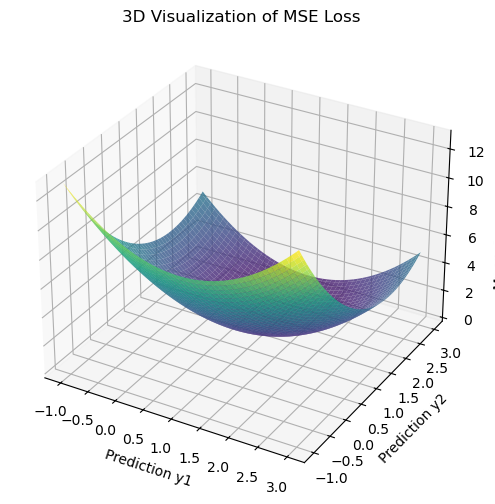

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Not mandatory in newer matplotlib but for clarity

# True values
t1, t2 = 1.0, 2.0

# Create a grid of predicted values
y1 = np.linspace(-1, 3, 100)
y2 = np.linspace(-1, 3, 100)
Y1, Y2 = np.meshgrid(y1, y2)

# Compute MSE over the grid
MSE = (t1 - Y1)**2 + (t2 - Y2)**2

# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Y1, Y2, MSE, cmap='viridis', alpha=0.8)
ax.set_xlabel('Prediction y1')
ax.set_ylabel('Prediction y2')
ax.set_zlabel('Mean Squared Error')
ax.set_title('3D Visualization of MSE Loss')

plt.show()


### 🛡️ Regularization Techniques

Regularization controls model complexity and helps generalization by penalizing overfit solutions.

#### 🧮 L1 and L2 Weight Penalties

- **L1 Regularization (Lasso)**:
  $$ \mathcal{L} = \mathcal{L}_{\text{original}} + \lambda \sum_i |w_i| $$
  - Encourages sparsity (many weights become exactly zero).
  - Feature selection effect.

- **L2 Regularization (Ridge)**:
  $$ \mathcal{L} = \mathcal{L}_{\text{original}} + \lambda \sum_i w_i^2 $$
  - Penalizes large weights, favors small distributed weights.
  - Smooths the solution and often improves stability.

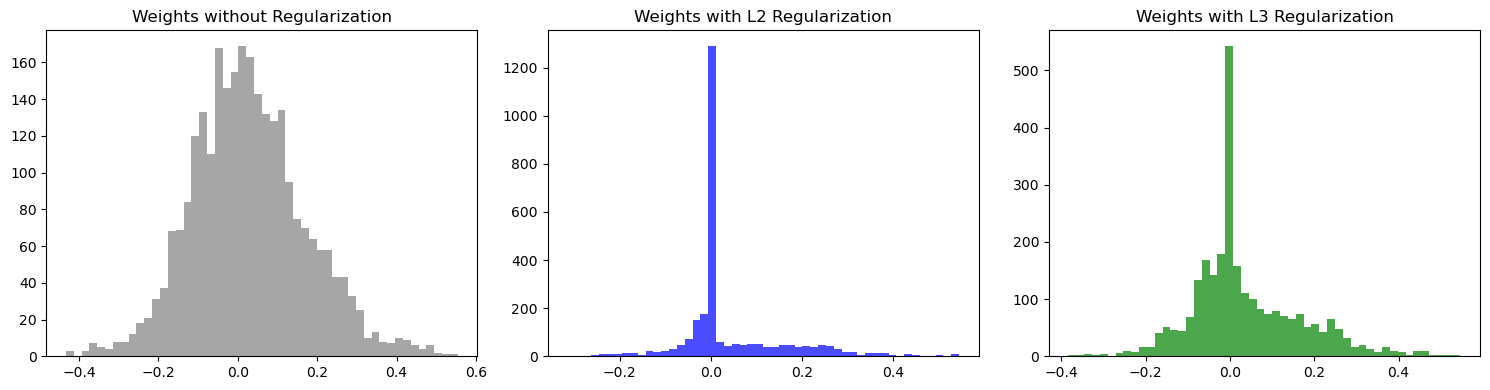

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Synthetic dataset: regression
np.random.seed(42)
X = np.random.rand(1000, 10).astype(np.float32)
true_weights = np.arange(1, 11).astype(np.float32) * 0.5
y = X @ true_weights + 0.1 * np.random.randn(1000).astype(np.float32)

X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y).unsqueeze(1)

# Deeper NN with 3 layers and ReLU activations
class DeepNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Training function with optional regularization
def train_model(reg='none', lambda_reg=0.01, epochs=200):
    model = DeepNN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = loss_fn(outputs, y_tensor)

        # Add regularization penalty on all weights (excluding biases)
        if reg == 'l2':
            l2_norm = 0
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l2_norm += (param ** 2).sum()
            loss += lambda_reg * l2_norm

        elif reg == 'l3':
            l3_norm = 0
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l3_norm += (param.abs() ** 3).sum()
            loss += lambda_reg * l3_norm

        loss.backward()
        optimizer.step()

    return model

# Train models
model_none = train_model('none')
model_l2 = train_model('l2', lambda_reg=0.01)
model_l3 = train_model('l3', lambda_reg=0.001)

# Extract all weights for each model (concatenate weights of all layers)
def get_all_weights(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.detach().cpu().numpy().flatten())
    return np.concatenate(weights)

weights_none = get_all_weights(model_none)
weights_l2 = get_all_weights(model_l2)
weights_l3 = get_all_weights(model_l3)

# Plot histograms
plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
plt.hist(weights_none, bins=50, color='gray', alpha=0.7)
plt.title('Weights without Regularization')

plt.subplot(1, 3, 2)
plt.hist(weights_l2, bins=50, color='blue', alpha=0.7)
plt.title('Weights with L2 Regularization')

plt.subplot(1, 3, 3)
plt.hist(weights_l3, bins=50, color='green', alpha=0.7)
plt.title('Weights with L3 Regularization')

plt.tight_layout()
plt.show()


#### 🪂 Dropout

- Randomly zeroes out a fraction $p$ of neurons during each training step:
  $$ h_i^{(l)} = \begin{cases} 
      0 & \text{with probability } p \\
      \frac{h_i^{(l)}}{1-p} & \text{otherwise (inverted dropout)}
    \end{cases} $$
  - Prevents co-adaptation.
  - Acts as model averaging over an exponential number of subnetworks.


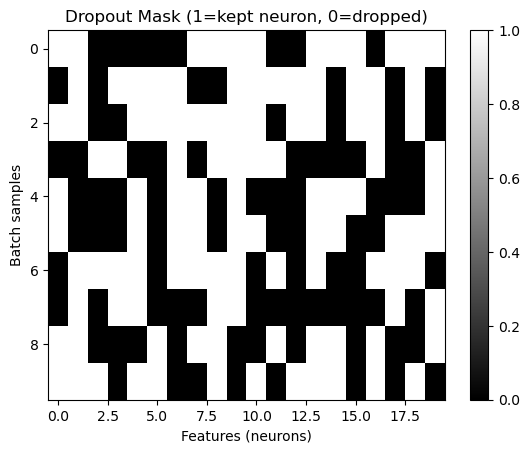

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

dropout = nn.Dropout(p=0.5)

# Simulate input batch of 10 samples with 20 features
x = torch.ones(10, 20)

# Dropout in train mode applies mask
dropout.train()
output = dropout(x)

# The mask is which elements remain (1) or dropped (0)
mask = (output != 0).float()

plt.imshow(mask.numpy(), cmap='gray', aspect='auto')
plt.title('Dropout Mask (1=kept neuron, 0=dropped)')
plt.xlabel('Features (neurons)')
plt.ylabel('Batch samples')
plt.colorbar()
plt.show()


#### ⚖️ Batch Normalization

- Standardizes the inputs to each layer to reduce internal covariate shift:
  $$ \hat{x} = \frac{x - \mu_{\text{batch}}}{\sqrt{\sigma^2_{\text{batch}} + \epsilon}} $$
  - Followed by learnable shift and scale parameters:
    $$ y = \gamma \hat{x} + \beta $$
  - Accelerates training.
  - Allows higher learning rates and provides mild regularization.

---

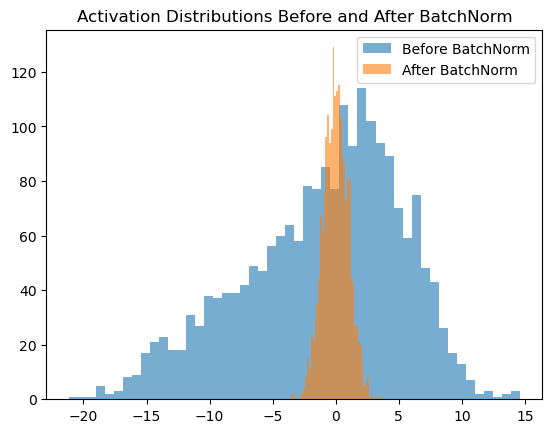

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Input: batch of 100 samples, 20 features each
x = torch.randn(100, 20) * 5 + 10  # intentionally wide distribution

# Linear layer
linear = nn.Linear(20, 20)

# BatchNorm layer
batchnorm = nn.BatchNorm1d(20)

# Forward pass
linear_out = linear(x)
bn_out = batchnorm(linear_out)

# Convert to numpy for plotting
linear_out_np = linear_out.detach().numpy().flatten()
bn_out_np = bn_out.detach().numpy().flatten()

plt.hist(linear_out_np, bins=50, alpha=0.6, label='Before BatchNorm')
plt.hist(bn_out_np, bins=50, alpha=0.6, label='After BatchNorm')
plt.legend()
plt.title("Activation Distributions Before and After BatchNorm")
plt.show()


---

### 🧱 Weight Initialization

Improper weight initialization can lead to exploding or vanishing gradients, hindering convergence.

- **Xavier (Glorot) Initialization**:
  $$ w \sim \mathcal{U} \left( -\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}} \right) $$
  - Suited for sigmoid and tanh activations.
  - Balances variance across layers.

- **He Initialization**:
  $$ w \sim \mathcal{N} \left( 0, \sqrt{\frac{2}{n_{in}}} \right) $$
  - Ideal for ReLU-family activations.

> 🎯 Goal: Preserve the variance of activations and gradients across layers.

---
    

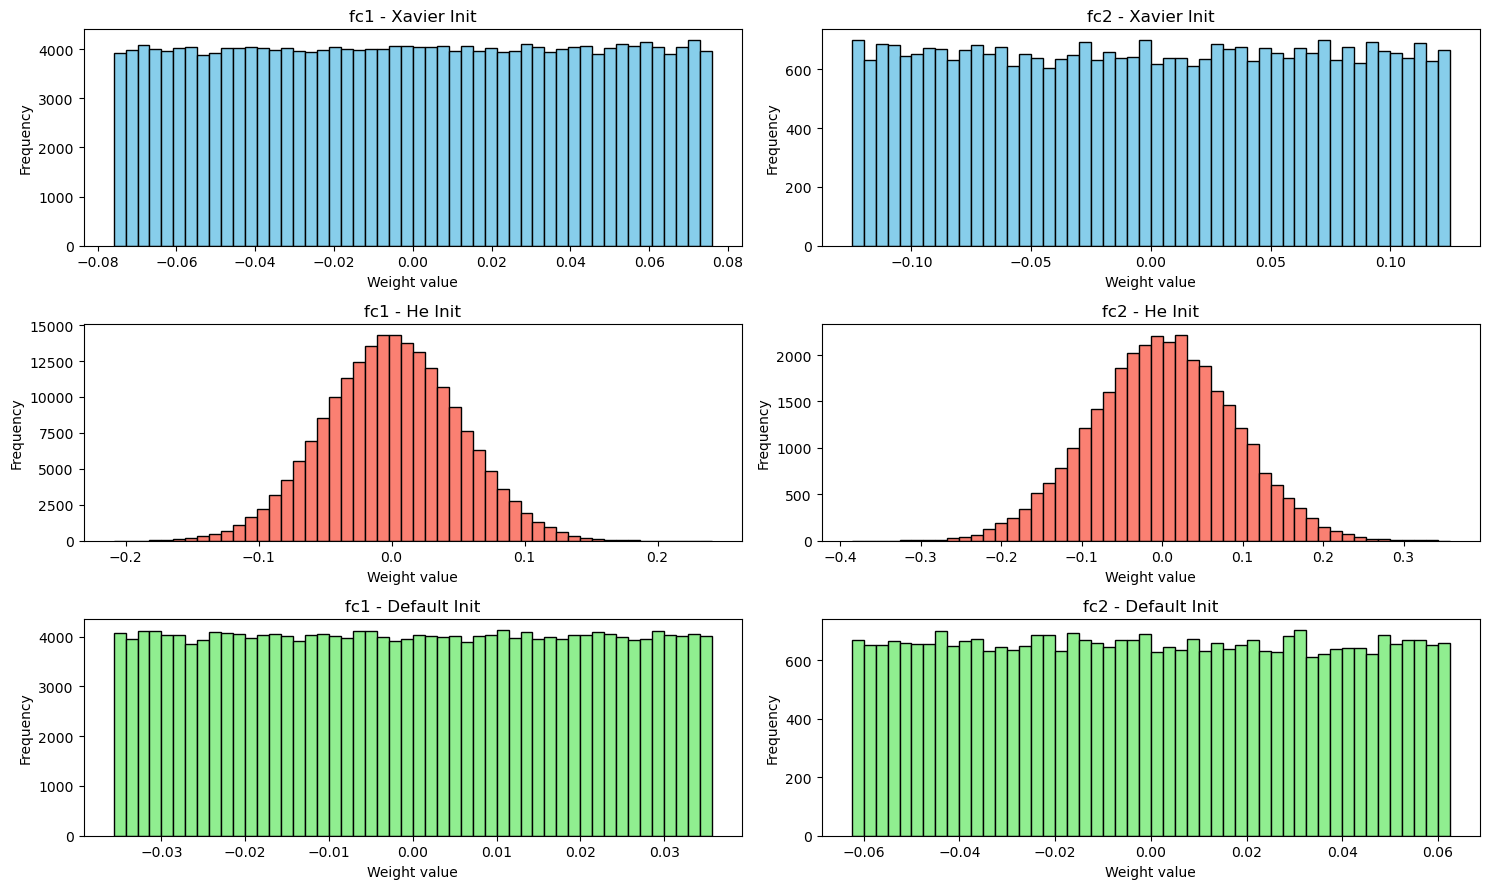

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def init_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Create three models
model_xavier = SimpleNet()
model_he = SimpleNet()
model_none = SimpleNet()  # default PyTorch initialization

# Apply initializations
model_xavier.apply(init_weights_xavier)
model_he.apply(init_weights_he)
# model_none stays with default init

def get_weights(model):
    weights = []
    names = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            weights.append(module.weight.detach().cpu().numpy().flatten())
            names.append(name if name else "fc1")
    return names, weights

names_x, weights_x = get_weights(model_xavier)
names_h, weights_h = get_weights(model_he)
names_n, weights_n = get_weights(model_none)

# Plotting
plt.figure(figsize=(15, 9))

for i, layer_name in enumerate(names_x):
    plt.subplot(3, len(names_x), i+1)
    plt.hist(weights_x[i], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'{layer_name} - Xavier Init')
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')

for i, layer_name in enumerate(names_h):
    plt.subplot(3, len(names_h), i+1+len(names_h))
    plt.hist(weights_h[i], bins=50, color='salmon', edgecolor='black')
    plt.title(f'{layer_name} - He Init')
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')

for i, layer_name in enumerate(names_n):
    plt.subplot(3, len(names_n), i+1+2*len(names_n))
    plt.hist(weights_n[i], bins=50, color='lightgreen', edgecolor='black')
    plt.title(f'{layer_name} - Default Init')
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### ⚖️ Overfitting vs. Underfitting

- **Overfitting**:
  - Training accuracy is high, but test accuracy is poor.
  - Model learns noise or irrelevant patterns.

- **Underfitting**:
  - Model fails to capture the underlying structure.
  - Poor performance on both training and test data.

**Mitigation Strategies**:
- Regularization (L1, L2, Dropout)
- Data augmentation
- Early stopping based on validation loss
- Reduce model complexity
- Add more training data

---